In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import DistanceMetric
from itertools import combinations
from matplotlib_venn import venn2, venn3
from scipy.stats import pearsonr, spearmanr
from load_data import *
from util import *

%matplotlib inline

In [2]:
path = '/media/clo302/3TB_RAID/data/TCGA_embedding/'
ref_path = '/media/clo302/3TB_RAID/ref/TCGA_RNASeq/'

In [3]:
gemb_CN, genes, semb_CN, sids_CN = load_data(path, ['gemb_CN.csv', 'semb_CN.csv'], return_rn=True)
gene2idx = {g:i for i, g in enumerate(genes)}
sid2ca, ca_cats = load_sid2ca(ref_path)
gene2gid = load_gene2gid(ref_path)

(20531, 50)
(9544, 50)
len: 10245
len: 20531


In [4]:
gene2idx = {g:i for i, g in enumerate(genes)}
sid2ca, ca_cats = load_sid2ca(ref_path)
gene2gid = load_gene2gid(ref_path)

len: 10245
len: 20531


### case study: IO responsiveness

In [5]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')

In [6]:
gemb_CN_dist = np.absolute(dist.pairwise(gemb_CN))
gemb_CN_dist_df = pd.DataFrame(gemb_CN_dist, index=genes, columns=genes)

In [7]:
io_responsive_ca = ['SKCM', 'LUSC']
io_notresponsive_ca = ['LIHC', 'PRAD']

In [8]:
arr_centroid = [find_centroid(semb_CN, sid2ca, sids_CN, cancer=c) for c in ['SKCM', 'LUSC', 'LIHC', 'PRAD']]
semb_centroid_df = pd.DataFrame(arr_centroid, index=['SKCM', 'LUSC', 'LIHC', 'PRAD'])

In [9]:
io_responsive_emb_mean = np.matrix(np.mean(np.array(semb_centroid_df.loc[io_responsive_ca,:]), axis=0))
io_notresponsive_emb_mean = np.matrix(np.mean(np.array(semb_centroid_df.loc[io_notresponsive_ca,:]), axis=0))
io_responsive_dp = np.array(np.dot(io_responsive_emb_mean, gemb_CN.T)).T
io_notresponsive_dp = np.array(np.dot(io_notresponsive_emb_mean, gemb_CN.T)).T

In [10]:
io_responsive_gene_l2dist = np.absolute(dist.pairwise(io_responsive_dp))
io_notresponsive_gene_l2dist = np.absolute(dist.pairwise(io_notresponsive_dp))
io_responsive_gene_l2dist_df = pd.DataFrame(data=io_responsive_gene_l2dist, index=genes, columns=genes)
io_notresponsive_gene_l2dist_df = pd.DataFrame(data=io_notresponsive_gene_l2dist, index=genes, columns=genes)

In [11]:
def find_remain_dist(mdf, dist_df, th):
    genes = list(set(mdf['child']))
    gene_combo = combinations(genes, 2)
    rows = [[g1, g2, dist_df[g1][g2]] for g1, g2 in gene_combo if dist_df[g1][g2] < th]
    remain_df = pd.DataFrame(rows, columns=['parent', 'child', 'l2dist'])
    tmp = pd.concat(mdf, remain_df)
    return tmp

In [12]:
def get_diff_nbs_mdf(r_df, nr_df, gemb_df, gene, th, gth=0.6):
    r_l2dist_mdf = pull_close_nbs(r_df, gene, th=th)
    nr_l2dist_mdf = pull_close_nbs(nr_df, gene, th=th)
    diff_nbs = list(set(r_l2dist_mdf['child']) - set(nr_l2dist_mdf['child']))
    gemb_l2dist_mdf = pull_close_nbs(gemb_df, gene, th=gth)
    close_nbs = list(gemb_l2dist_mdf['child'])
    diff_nbs_sig = [g for g in diff_nbs if g in close_nbs]
    #r_l2dist_mdf = find_remain_dist(r_l2dist_mdf, r_df, th=th)
    #nr_l2dist_mdf = find_remain_dist(nr_l2dist_mdf, nr_df, th=th)
    r_l2dist_mdf = r_l2dist_mdf.assign(group='Responsive')
    nr_l2dist_mdf = nr_l2dist_mdf.assign(group='Unresponsive')
    mdf = pd.concat([r_l2dist_mdf, nr_l2dist_mdf])
    sig = np.where(mdf['child'].isin(diff_nbs_sig), 'Sig', 'NA')
    mdf = mdf.assign(sig=sig)
    print(len(diff_nbs_sig))
    print(diff_nbs_sig)
    gsets = [set(r_l2dist_mdf['child']), set(nr_l2dist_mdf['child']), set(gemb_l2dist_mdf['child'])]
    return mdf, gsets

In [13]:
pdl1_diff_nbs, pdl1_gsets = get_diff_nbs_mdf(io_responsive_gene_l2dist_df, io_notresponsive_gene_l2dist_df, gemb_CN_dist_df, 'CD274', th=0.1)

13
['SLFN12', 'TTC39B', 'RASGEF1B', 'C11orf45', 'FER', 'MCTP1', 'IL18R1', 'CD101', 'GNLY', 'CLEC7A', 'GPR183', 'CLIC2', 'CMPK2']


In [14]:
pd1_diff_nbs, pd1_gsets = get_diff_nbs_mdf(io_responsive_gene_l2dist_df, io_notresponsive_gene_l2dist_df, gemb_CN_dist_df, 'PDCD1', th=0.1)

26
['CLEC10A', 'CST7', 'CYTIP', 'ZAP70', 'LAT', 'LTB', 'TRAF3IP3', 'CD79B', 'CD96', 'ZBP1', 'CD5', 'ITK', 'CXCR2P1', 'PTPRCAP', 'CD247', 'CD3D', 'TNFRSF8', 'CRTAM', 'CXCR6', 'GZMK', 'TBC1D10C', 'GZMH', 'CD28', 'CD8B', 'CFP', 'EOMES']


In [15]:
ctla4_diff_nbs, ctla4_gsets = get_diff_nbs_mdf(io_responsive_gene_l2dist_df, io_notresponsive_gene_l2dist_df, gemb_CN_dist_df, 'CTLA4', th=0.1)

34
['CCR5', 'GZMA', 'LCK', 'MAP4K1', 'CST7', 'MGC29506', 'CD2', 'CYTIP', 'ZAP70', 'CTSW', 'FCRLA', 'CXCR3', 'FCRL5', 'LTB', 'TRAF3IP3', 'KLRK1', 'CD96', 'SLAMF6', 'TNFRSF9', 'MMP25', 'CXCL11', 'CD5', 'ITK', 'CD6', 'PTPRCAP', 'CD247', 'CD3D', 'TNFRSF8', 'ACAP1', 'CXCR6', 'GZMH', 'CD28', 'CD8B', 'CD27']


In [16]:
pdl1_diff_nbs.to_csv(path+'pdl1_nbs.csv')
pd1_diff_nbs.to_csv(path+'pd1_nbs.csv')
ctla4_diff_nbs.to_csv(path+'ctla4_nbs.csv')

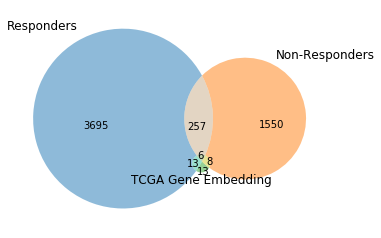

In [17]:
venn3(pdl1_gsets, set_colors=('C0', 'C1', 'C2'), alpha=0.5, set_labels=('Responders', 'Non-Responders', 'TCGA Gene Embedding'))

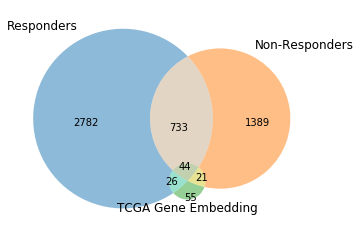

In [18]:
venn3(pd1_gsets, set_colors=('C0', 'C1', 'C2'), alpha=0.5, set_labels=('Responders', 'Non-Responders', 'TCGA Gene Embedding'))

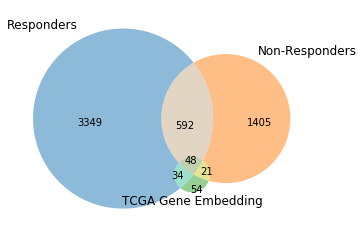

In [19]:
venn3(ctla4_gsets, set_colors=('C0', 'C1', 'C2'), alpha=0.5, set_labels=('Responders', 'Non-Responders', 'TCGA Gene Embedding'))

### co-expression

In [21]:
df = load_raw(ref_path)

In [26]:
df = pd.DataFrame(df, index=sids_CN, columns=genes)

In [27]:
io_ca = ['SKCM', 'LUSC']
io_sid_idx = [s for s in sids_CN if sid2ca[s] in io_ca]

In [28]:
io_raw_df = df.loc[io_sids]

In [29]:
pd1_nbs = ['SLFN12', 'TTC39B', 'RASGEF1B', 'C11orf45', 'FER', 'MCTP1', 'IL18R1', 'CD101', 'GNLY', 'CLEC7A', 'GPR183', 'CLIC2', 'CMPK2']
pdl1_nbs = ['CLEC10A', 'CST7', 'CYTIP', 'ZAP70', 'LAT', 'LTB', 'TRAF3IP3', 'CD79B', 'CD96', 'ZBP1', 'CD5', 'ITK', 'CXCR2P1', 'PTPRCAP', 'CD247', 'CD3D', 'TNFRSF8', 'CRTAM', 'CXCR6', 'GZMK', 'TBC1D10C', 'GZMH', 'CD28', 'CD8B', 'CFP', 'EOMES']
ctla4_nbs = ['CCR5', 'GZMA', 'LCK', 'MAP4K1', 'CST7', 'MGC29506', 'CD2', 'CYTIP', 'ZAP70', 'CTSW', 'FCRLA', 'CXCR3', 'FCRL5', 'LTB', 'TRAF3IP3', 'KLRK1', 'CD96', 'SLAMF6', 'TNFRSF9', 'MMP25', 'CXCL11', 'CD5', 'ITK', 'CD6', 'PTPRCAP', 'CD247', 'CD3D', 'TNFRSF8', 'ACAP1', 'CXCR6', 'GZMH', 'CD28', 'CD8B', 'CD27']

In [30]:
def get_correlations(df, x, y_arr):
    ptmp = [pearsonr(df[x], df[y]) for y in y_arr]
    prs = [ptmp[i][0] for i in range(len(ptmp))]
    pps = [ptmp[i][1] for i in range(len(ptmp))]
    stmp = [spearmanr(df[x], df[y]) for y in y_arr]
    srs = [stmp[i][0] for i in range(len(stmp))]
    sps = [stmp[i][1] for i in range(len(stmp))]
    tmp = list(map(list, zip(*[prs, pps, srs, sps])))
    tdf = pd.DataFrame(tmp, index=y_arr, columns=['pearson_r', 'pearson_p', 'spearman_r', 'spearman_p'])
    return tdf

In [31]:
pd1_nbs_corr_df = get_correlations(io_raw_df, 'PDCD1', pd1_nbs)
pdl1_nbs_corr_df = get_correlations(io_raw_df, 'CD274', pdl1_nbs)
ctla4_nbs_corr_df = get_correlations(io_raw_df, 'CTLA4', ctla4_nbs)

In [34]:
pd1_nbs_corr_df

,pearson_r,pearson_p,spearman_r,spearman_p
SLFN12,0.240107,3.166009e-14,0.202974,1.660634e-10
TTC39B,0.116714,2.638195e-04,0.051866,1.059055e-01
RASGEF1B,0.395417,9.110061e-38,0.355636,2.202719e-30
C11orf45,0.164656,2.407123e-07,0.081479,1.100557e-02
FER,-0.112137,4.575681e-04,-0.084514,8.350493e-03
MCTP1,0.177252,2.606014e-08,0.166330,1.808392e-07
IL18R1,0.406187,6.013075e-40,0.361915,1.758270e-31
CD101,0.381252,5.091132e-35,0.362722,1.265121e-31
GNLY,0.664702,4.369592e-125,0.649845,7.978202e-118
CLEC7A,0.453519,1.577125e-50,0.402228,3.889533e-39


In [32]:
pdl1_nbs_corr_df

,pearson_r,pearson_p,spearman_r,spearman_p
CLEC10A,0.397769,3.091436e-38,0.390241,9.526293e-37
CST7,0.418291,1.703698e-42,0.397296,3.844019e-38
CYTIP,0.588812,7.495953e-92,0.590851,1.246126e-92
ZAP70,0.406119,6.209745e-40,0.411745,4.189048e-41
LAT,0.228216,5.810566e-13,0.227919,6.235998e-13
LTB,0.406887,4.311683e-40,0.395668,8.120503e-38
TRAF3IP3,0.502221,2.639881e-63,0.506119,2.028308e-64
CD79B,0.206124,8.516725e-11,0.231676,2.533172e-13
CD96,0.570250,5.254822e-85,0.565313,2.942795e-83
ZBP1,0.560355,1.566512e-81,0.548928,1.159189e-77


In [33]:
ctla4_nbs_corr_df

,pearson_r,pearson_p,spearman_r,spearman_p
CCR5,0.637703,3.467570e-112,0.675995,6.837390e-131
GZMA,0.612259,3.689859e-101,0.632860,5.231667e-110
LCK,0.629380,1.820999e-108,0.672405,5.110072e-129
MAP4K1,0.518989,3.333499e-68,0.567873,3.680394e-84
CST7,0.639869,3.571047e-113,0.663581,1.595523e-124
MGC29506,0.471348,5.729949e-55,0.494194,4.695256e-61
CD2,0.658446,5.605152e-122,0.705417,2.589625e-147
CYTIP,0.591653,6.132533e-93,0.636071,1.900087e-111
ZAP70,0.599678,4.541866e-96,0.649591,1.053500e-117
CTSW,0.598698,1.107315e-95,0.622915,1.183187e-105


In [35]:
pd1_nbs_corr_df.to_csv(path+'pd1_io_nbs_corr.csv')
pdl1_nbs_corr_df.to_csv(path+'pdl1_io_nbs_corr.csv')
ctla4_nbs_corr_df.to_csv(path+'ctla4_io_nbs_corr.csv')